# Preparing Data for Models

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

import matplotlib.pyplot as plt
import seaborn as sns

We'll be using the TA-LIB library for handling technical indicators on the Stock Data. The below list of indicators is not by all means complete and will be tweaked for better performance

In [3]:

from talib import RSI, BBANDS, MACD, NATR, ATR, ULTOSC

In [4]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

The available crypto( Only BTC for now) are available in data/assets.h5

In [5]:
DATA_STORE = 'data/assets.h5'

In [10]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['Crypto/prices']
              .dropna())

In [11]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1030 entries, 2019-03-08 to 2022-03-10
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   1030 non-null   float64
 1   open    1030 non-null   float64
 2   high    1030 non-null   float64
 3   low     1030 non-null   float64
dtypes: float64(4)
memory usage: 40.2 KB


In [12]:
prices.close

date
2019-03-08     3865.9
2019-03-09     3944.4
2019-03-10     3915.2
2019-03-11     3865.1
2019-03-12     3886.0
               ...   
2022-03-06    37951.3
2022-03-07    38487.5
2022-03-08    41623.2
2022-03-09    39648.0
2022-03-10    38491.0
Name: close, Length: 1030, dtype: float64

## Adding Technical Indicators

In [13]:
prices['rsi'] = RSI(prices.close)
prices

,close,open,high,low,rsi
date,,,,,
2019-03-08,3865.9,3875.1,3929.0,3810.7,NaN
2019-03-09,3944.4,3865.9,3964.0,3859.7,NaN
2019-03-10,3915.2,3944.3,3944.5,3889.2,NaN
2019-03-11,3865.1,3915.6,3935.5,3842.4,NaN
2019-03-12,3886.0,3870.3,3900.1,3817.1,NaN
...,...,...,...,...,...
2022-03-06,37951.3,39468.9,38543.2,37597.7,43.838689
2022-03-07,38487.5,37931.7,38935.0,37886.6,45.230091
2022-03-08,41623.2,38558.0,41793.9,38663.3,52.622412


<AxesSubplot:xlabel='rsi', ylabel='Density'>

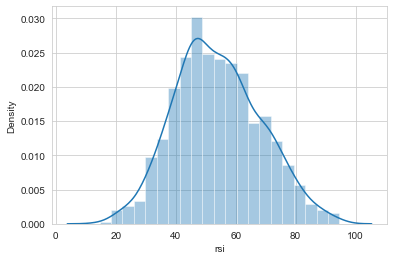

In [14]:
sns.distplot(prices.rsi)

In [15]:
def compute_bb(close):
    high, mid, low = BBANDS(np.log1p(close), timeperiod=20)
    return pd.DataFrame({'bb_high': high,
                         'bb_mid': mid,
                         'bb_low': low}, index=close.index)

In [16]:

temp = compute_bb(prices.close)
prices =prices.join(temp)

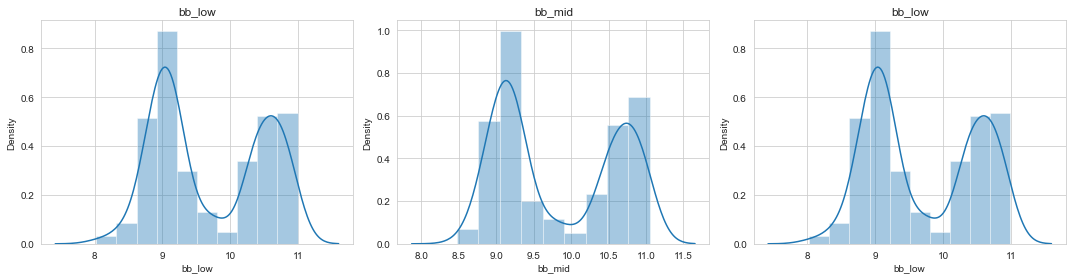

In [17]:
fig, axes = plt.subplots(ncols=3, figsize=(15,4))
for i, col in enumerate(['bb_low', 'bb_mid', 'bb_low']):
    sns.distplot(prices[col], ax=axes[i])
    axes[i].set_title(col)
fig.tight_layout()

In [18]:
prices['bb_up'] = prices.bb_high.sub(np.log1p(prices.close))
prices['bb_down'] = np.log1p(prices.close).sub(prices.bb_low)

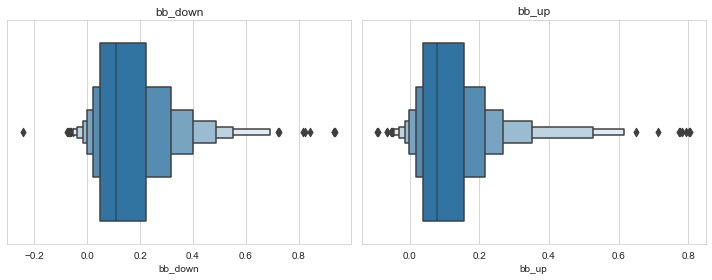

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
for i, col in enumerate(['bb_down', 'bb_up']):
    sns.boxenplot(prices[col], ax=axes[i])
    axes[i].set_title(col)
fig.tight_layout()

In [20]:
def compute_atr(stock_data):
    atr = ATR(stock_data['high'], 
              stock_data["low"], 
              stock_data['close'], 
              timeperiod=14)
    return atr.sub(atr.mean()).div(atr.std())
def compute_natr(stock_data):
    natr = NATR(stock_data['high'], 
              stock_data["low"], 
              stock_data['close'], 
              timeperiod=14)
    return natr

In [21]:
prices['atr'] = compute_atr(prices)

<AxesSubplot:xlabel='atr', ylabel='Density'>

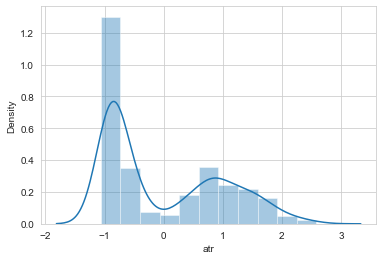

In [22]:


sns.distplot(prices.atr)

In [23]:
prices['natr'] = compute_natr(prices)

<AxesSubplot:xlabel='natr', ylabel='Density'>

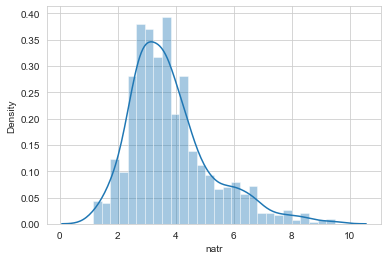

In [24]:
sns.distplot(prices.natr[prices.natr<10])

<AxesSubplot:xlabel='macd', ylabel='Density'>

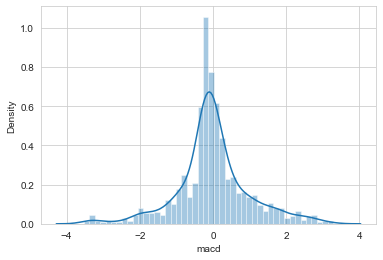

In [26]:

def compute_macd(close):
    macd = MACD(close)[0]
    return macd.sub(macd.mean()).div(macd.std())

prices['macd'] = compute_macd(prices['close'])
sns.distplot(prices.macd)


<AxesSubplot:xlabel='ULTOSC', ylabel='Density'>

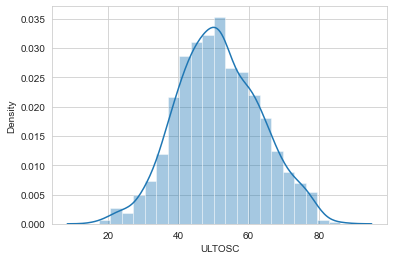

In [27]:

def compute_ULTOSC(stock_data):
    ultosc = ULTOSC(stock_data['high'], 
              stock_data["low"], 
              stock_data['close'], timeperiod1=7, timeperiod2=14, timeperiod3=28)
    return ultosc

prices['ULTOSC'] = compute_ULTOSC(prices)
sns.distplot(prices.ULTOSC)


In [28]:
prices.info

<bound method DataFrame.info of               close     open     high      low        rsi    bb_high  \
date                                                                   
2019-03-08   3865.9   3875.1   3929.0   3810.7        NaN        NaN   
2019-03-09   3944.4   3865.9   3964.0   3859.7        NaN        NaN   
2019-03-10   3915.2   3944.3   3944.5   3889.2        NaN        NaN   
2019-03-11   3865.1   3915.6   3935.5   3842.4        NaN        NaN   
2019-03-12   3886.0   3870.3   3900.1   3817.1        NaN        NaN   
...             ...      ...      ...      ...        ...        ...   
2022-03-06  37951.3  39468.9  38543.2  37597.7  43.838689  10.736968   
2022-03-07  38487.5  37931.7  38935.0  37886.6  45.230091  10.732980   
2022-03-08  41623.2  38558.0  41793.9  38663.3  52.622412  10.726853   
2022-03-09  39648.0  41637.0  42029.1  39466.2  48.208500  10.714998   
2022-03-10  38491.0  39543.1  39431.9  38236.4  45.785847  10.701949   

               bb_mid     bb_lo

Calculating the return values for each day as the "Target" value to train the models on.

In [29]:
a = list(prices[1:]['close'].values/prices['close'][:-1].values - 1)
a.extend([np.nan])
prices['Target'] = np.array(a)
prices

,close,open,high,low,rsi,bb_high,bb_mid,bb_low,bb_up,bb_down,atr,natr,macd,ULTOSC,Target
date,,,,,,,,,,,,,,,
2019-03-08,3865.9,3875.1,3929.0,3810.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.020306
2019-03-09,3944.4,3865.9,3964.0,3859.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.007403
2019-03-10,3915.2,3944.3,3944.5,3889.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.012796
2019-03-11,3865.1,3915.6,3935.5,3842.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005407
2019-03-12,3886.0,3870.3,3900.1,3817.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.005430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-06,37951.3,39468.9,38543.2,37597.7,43.838689,10.736968,10.604933,10.472898,0.192882,0.071187,1.157787,5.424304,-0.131578,47.015345,0.014129
2022-03-07,38487.5,37931.7,38935.0,37886.6,45.230091,10.732980,10.600674,10.468368,0.174865,0.089746,1.075734,5.161253,-0.245968,48.302288,0.081473
2022-03-08,41623.2,38558.0,41793.9,38663.3,52.622412,10.726853,10.598488,10.470122,0.090416,0.166315,1.182948,4.998943,-0.167280,54.537696,-0.047454


In [30]:
prices = prices.dropna()
prices

,close,open,high,low,rsi,bb_high,bb_mid,bb_low,bb_up,bb_down,atr,natr,macd,ULTOSC,Target
date,,,,,,,,,,,,,,,
2019-05-25,8015.8,8009.9,8046.5,7997.6,72.124449,9.116024,8.894723,8.673422,0.126729,0.315872,-0.842657,3.735326,0.526725,51.734117,0.081190
2019-05-26,8666.6,7986.2,8838.9,8627.9,77.228970,9.126078,8.913573,8.701069,0.058730,0.366278,-0.800121,3.886440,0.529964,60.182545,0.013373
2019-05-27,8782.5,8745.3,8794.1,8724.6,78.001551,9.129008,8.933630,8.738252,0.048377,0.342378,-0.817123,3.664909,0.530787,61.370544,-0.015713
2019-05-28,8644.5,8772.6,8715.6,8617.6,74.749552,9.126294,8.951213,8.776132,0.061499,0.288662,-0.829873,3.593712,0.516155,59.262653,-0.006235
2019-05-29,8590.6,8656.4,8715.1,8558.5,73.461302,9.117993,8.967312,8.816632,0.059452,0.241909,-0.842386,3.488165,0.494069,62.278006,-0.028892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-03,42449.2,43912.8,44077.2,41840.8,54.653749,10.740591,10.610242,10.479892,0.084504,0.176195,0.913484,4.343438,0.050493,57.935356,-0.105960
2022-03-06,37951.3,39468.9,38543.2,37597.7,43.838689,10.736968,10.604933,10.472898,0.192882,0.071187,1.157787,5.424304,-0.131578,47.015345,0.014129
2022-03-07,38487.5,37931.7,38935.0,37886.6,45.230091,10.732980,10.600674,10.468368,0.174865,0.089746,1.075734,5.161253,-0.245968,48.302288,0.081473


The final data is stored in data.h5.

In [168]:

with pd.HDFStore('data.h5') as store:
    store.put('CRYPTO/DAILY', prices)

